# Notebook with PCA model and no conditionning

## Loading Libraries 

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
import umap
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images

In [2]:
#paths in git

#root git folder 
path_main_folder = '/home/goubetcle/Documents/CVAE/marota_cvae'
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [3]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import NEpochLogger,callbackWeightLoss
#from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE, CVAE_emb, CAE
from conso.load_shape_data import *  

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [4]:
#directories to store trained model and the related projector

log_dir_projector=path_main_folder+"/notebooks/logs/Expe-bike/PCA/projector"
log_dir_model=path_main_folder+"/notebooks/logs/Expe-bike/PCA/model"
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)

# Table of contents:
- Load Data
- Make Training Set
- Define and Train Model
- Build Projector
- Compute Feature Scores in latent space
- Study reconstruction Error
- Study Holidays prediction
- Detect atypical events
- Conclusion

# Load dataset 

In [5]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data/bike-sharing')
dataset_train= os.path.join(path_data, "train.csv")
dataset_test= os.path.join(path_data, "test.csv")

train = pd.read_csv(dataset_train)
test = pd.read_csv(dataset_test)
train.head()
train.datetime = pd.to_datetime(train.datetime)

In [6]:
dates, freq = np.unique(train.datetime.dt.date, return_counts=True)
stats.describe(freq)

DescribeResult(nobs=456, minmax=(12, 24), mean=23.87280701754386, variance=0.4233468286099864, skewness=-13.815185164323347, kurtosis=242.2238235069406)

In [7]:
target = dates[np.argmin(freq)]
ind = np.where(train.datetime.dt.date==target)[0]
train = train.drop(index=ind)

In [8]:
#Visualize data frame head
x_conso = train[['datetime', 'count', 'temp', 'humidity', 'windspeed', 'holiday']].copy()
x_conso[['count', 'temp', 'humidity', 'windspeed', 'holiday']] = x_conso[['count', 'temp', 'humidity', 'windspeed', 'holiday']].astype('float64').values
x_conso = x_conso.rename(columns={'datetime':'ds', 'count':'consumption', 'temp':'temperature', 'holiday':'is_holiday_day'})
x_conso.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10874 entries, 0 to 10885
Data columns (total 6 columns):
ds                10874 non-null datetime64[ns]
consumption       10874 non-null float64
temperature       10874 non-null float64
humidity          10874 non-null float64
windspeed         10874 non-null float64
is_holiday_day    10874 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 594.7 KB


In [9]:
#Visualize data frame head
x_conso.head(5)

,ds,consumption,temperature,humidity,windspeed,is_holiday_day
0,2011-01-01 00:00:00,16.0,9.84,81.0,0.0,0.0
1,2011-01-01 01:00:00,40.0,9.02,80.0,0.0,0.0
2,2011-01-01 02:00:00,32.0,9.02,80.0,0.0,0.0
3,2011-01-01 03:00:00,13.0,9.84,75.0,0.0,0.0
4,2011-01-01 04:00:00,1.0,9.84,75.0,0.0,0.0


# Make training set of daily electrical consumption profiles and conditions 
In this experiment there is no condition to pass. This is not something we can do with a PCA anyway

In [10]:
dict_xconso = {'train': x_conso}
name_set_plot = 'train'
version = '-v1'
# Normalize input variables
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard', meteo_elements=['temperature', 'humidity', 'windspeed'])
dict_xconso['train'].describe()

['consumption']


,consumption,temperature,humidity,windspeed,is_holiday_day
count,1.087400e+04,1.087400e+04,1.087400e+04,1.087400e+04,10874.000000
mean,-4.181969e-17,-1.150042e-16,-8.886685e-17,9.409431e-17,0.028600
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,0.166688
min,-1.052696e+00,-2.494529e+00,-3.215629e+00,-1.567853e+00,0.000000
25%,-8.208763e-01,-8.095381e-01,-7.724447e-01,-7.104285e-01,0.000000
50%,-2.578865e-01,3.295719e-02,7.294971e-03,2.392095e-02,0.000000
75%,5.093251e-01,7.701406e-01,7.870346e-01,5.137608e-01,0.000000
max,4.334344e+00,2.665755e+00,1.982635e+00,5.412159e+00,1.000000


In [11]:
timeserie = train.datetime.dt
nPoints = len(np.unique(timeserie.date))
nPoints

455

In [12]:
# Normalize input variables
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption']


In [13]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)

month (455, 12)
weekday (455, 1)
(455, 13)


In [14]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0

In [15]:
calendar_info.isna().sum()

ds                0
month             0
weekday           0
is_weekday        0
is_holiday_day    0
dtype: int64

In [16]:
sum(np.isnan(dataset['train']['y']))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [17]:
dates = calendar_info['ds'].dt.date
weather = [train.weather.iloc[np.where(train['datetime'].dt.date==date)[0]].max() for date in dates]
calendar_info=calendar_info.join(pd.get_dummies(weather).rename(columns={1:'clear', 2:'mist', 3:'significant', 4:'extreme'}))
calendar_info.head()

,ds,month,weekday,is_weekday,is_holiday_day,clear,mist,significant,extreme
0,2011-01-01,1,5,0,0.0,0,0,1,0
1,2011-01-02,1,6,0,0.0,0,0,1,0
2,2011-01-03,1,0,1,0.0,1,0,0,0
3,2011-01-04,1,1,1,0.0,0,1,0,0
4,2011-01-05,1,2,1,0.0,1,0,0,0


In [18]:
calendar_info.describe()

,month,weekday,is_weekday,is_holiday_day,clear,mist,significant,extreme
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,6.512088,3.013187,0.709890,0.028571,0.224176,0.364835,0.408791,0.002198
std,3.449984,2.006554,0.454312,0.166782,0.417497,0.481914,0.492152,0.046881
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.500000,5.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,12.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Build and learn PCA model

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
umap_emb = umap.UMAP(n_neighbors=5, n_components = 3, metric='mahalanobis')

In [20]:
x = dataset['train']['x'][0]

In [21]:
from sklearn.model_selection import KFold # import KFold
import sklearn as sk
kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(x) # returns the number of splitting iterations in the cross-validator

for train_index, test_index in kf.split(x):
    #print('TRAIN:', train_index, 'TEST:', test_index)
    X_train, X_test = x[train_index], x[test_index]
    principalComponents = pca.fit_transform(X_train)
    X_test_pca=pca.transform(X_test)
    x_hat = pca.inverse_transform(X_test_pca)
    print("mae loss:")
    print(sk.metrics.mean_absolute_error(X_test,x_hat))
    print("mse loss:")
    print(sk.metrics.mean_squared_error(X_test,x_hat))
   # y_train, y_test = y[train_index], y[test_index]

mae loss:
0.09744397798167415
mse loss:
0.031098803805702794
mae loss:
0.11501521347480108
mse loss:
0.027576430664599277
mae loss:
0.09439055969045713
mse loss:
0.01913100957719772
mae loss:
0.14371421871630832
mse loss:
0.046908204125484985
mae loss:
0.1318261430134771
mse loss:
0.037034835207297175


In [25]:
pca.explained_variance_ratio_

array([0.59168168, 0.31514314, 0.02579744])

In [23]:
x_encoded_umap = umap_emb.fit_transform(x)

/home/goubetcle/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 4 separate connected components using meta-embedding (experimental)



In [26]:
filename = log_dir_model+'/pca.sav'
pickle.dump(pca, open(filename, 'wb'))

In [25]:
x_encoded=pca.transform(x)
x_hat = pca.inverse_transform(x_encoded)

In [28]:
import sklearn as sk
print("mae loss:")
sk.metrics.mean_absolute_error(x,x_hat)


mae loss:


0.1122488012515462

# Analysis of the latent space with the construction of a tensorboard projector

In [26]:
includeConsumptionProfileImages=True #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
if includeConsumptionProfileImages:
    nPoints=min(1500,nPoints) #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
    x_encoded_reduced=x_encoded[0:nPoints,]
    images=createLoadProfileImages(x,x_hat,nPoints)
else:
    nPoints=nPoints

<Figure size 432x288 with 0 Axes>

In [27]:
if includeConsumptionProfileImages:
    sprites=images_to_sprite(images)
    cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)

In [28]:

writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
if includeConsumptionProfileImages:
    buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
else:
    buildProjector(x_encoded,images=None, log_dir=log_dir_projector)

Instructions for updating:
Colocations handled automatically by placer.


In [29]:
log_dir_projector

'/home/goubetcle/Documents/CVAE/marota_cvae/notebooks/logs/Expe-bike/PCA/projector'

# Predict Features in latent space

In [30]:
df_noCond_PCA=predictFeaturesInLatentSPace(x_conso,calendar_info,x_encoded_umap)

/home/goubetcle/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/goubetcle/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/goubetcle/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/goubetcle/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/goubetcle/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/goub

11.856189855072456
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.889028  0.442740  0.178871        0.076923    -2.347052
random model    0.443429  0.115004  0.068233        0.030769    -5.688194


# reconstruction error analysis

In [34]:
error=np.sum(np.abs((x - x_hat)),axis=1)/24

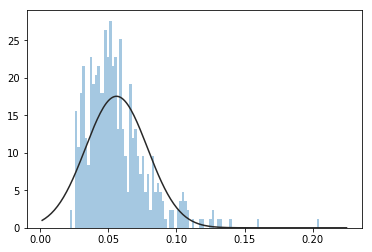

In [35]:
#make a histogram over residuals
import seaborn as sn
sn.distplot(error, kde=False, fit=stats.norm, bins=100)

Check the day with errors above a threshold

In [37]:
ErrorThreshold=0.12
idxMaxError=[i for i in range(0,nPoints) if error[i]>=ErrorThreshold]
calender_error=calendar_info.loc[idxMaxError]
calender_error['error']=error[idxMaxError]

calender_error

,ds,month,weekday,is_weekday,is_holiday_day,error
275,2012-03-11,3,6,0,0.0,0.127793
311,2012-05-09,5,2,1,0.0,0.133109
317,2012-05-15,5,1,1,0.0,0.126565
344,2012-07-04,7,2,1,1.0,0.204666
350,2012-07-10,7,1,1,0.0,0.140347
378,2012-08-19,8,6,0,0.0,0.160251
386,2012-09-08,9,5,0,0.0,0.131321
416,2012-10-19,10,4,1,0.0,0.124239


Check the first n days with highest errors 

In [38]:
nDays=30

decreasingOrderIdx=np.argsort(-error)
calendar_Error_Highest=calendar_info.loc[decreasingOrderIdx[0:nDays]]
calendar_Error_Highest['error']=error[decreasingOrderIdx[0:nDays]]
calendar_Error_Highest

,ds,month,weekday,is_weekday,is_holiday_day,error
344,2012-07-04,7,2,1,1.0,0.204666
378,2012-08-19,8,6,0,0.0,0.160251
350,2012-07-10,7,1,1,0.0,0.140347
311,2012-05-09,5,2,1,0.0,0.133109
386,2012-09-08,9,5,0,0.0,0.131321
275,2012-03-11,3,6,0,0.0,0.127793
317,2012-05-15,5,1,1,0.0,0.126565
416,2012-10-19,10,4,1,0.0,0.124239
358,2012-07-18,7,2,1,0.0,0.119974
289,2012-04-06,4,4,1,0.0,0.118170


Visualize the reconstruction error over a specific day

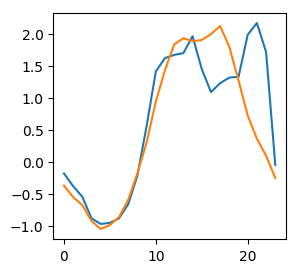

In [40]:
indice=344 #1185 is the changing hour day end of march
fig = plt.figure(dpi=100,figsize=(3,3))
#set(gca,'Color','k')
plt.plot(x[indice,:])
plt.plot(x_hat[indice,:])

Visualize the reconstruction error over the days with highest error

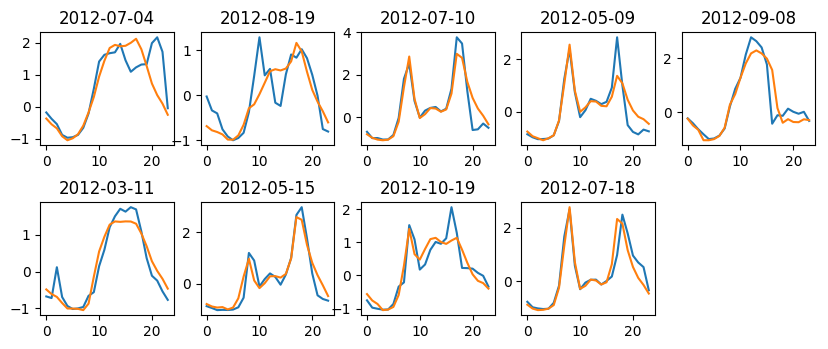

In [41]:
nPlots=10#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,2*nRows))
for i in range(1, nPlots):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=decreasingOrderIdx[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_Error_Highest.ds.dt.date.iloc[i-1])

2013-03-31 is the day with a missing hour because of changing day time and the consumption value is set to 0. It is hence normal that it is not well predicted and a good indicator that the model does not tend to overfit.

# Study of weekday predictions

In [42]:
#preparation des features d'interet
yWd=calendar_info['is_holiday_day'].astype(int)
indicesHd=np.array([i for i in range(0, nPoints) if yHd[i] == 1])
yHd_only=yHd[yHd==1]
x_encoded_Hd=x_encoded[indicesHd,]

In [66]:
yHd.describe()

count    455.000000
mean       0.028571
std        0.166782
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: is_holiday_day, dtype: float64

In [68]:
results_hd=scoreKnnResults(x_encoded,yHd,type='classifier',k=5,cv=10)
print(results_hd)


{'F1': 0.4927823915757477, 'predD': 0.9715859800596156, 'predP': [0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

/home/goubetcle/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/goubetcle/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/goubetcle/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/goubetcle/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/goubetcle/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/goub

## holidays well predicted

In [44]:
results_hd_only=[results_hd['predP'][i] for i in indicesHd ]
indices_Hd_predict=[i for i in indicesHd if  results_hd['predP'][i]>=0.5]
indices_Hd_not_predicted=[i for i in indicesHd if  results_hd['predP'][i]<0.5]
calendar_info.loc[indices_Hd_predict]

,ds,month,weekday,is_weekday,is_holiday_day


In [45]:
yWeekday=calendar_info['is_weekday']
results_wk=scoreKnnResults(x_encoded,yWeekday,type='classifier',k=10,cv=10)



In [47]:
weekdays_predicted_as_weekend=[i for i in range(0,nPoints) if  results_wk['predP'][i]<=0.5 and yWeekday[i]==1]
calendar_info.loc[weekdays_predicted_as_weekend]

,ds,month,weekday,is_weekday,is_holiday_day
16,2011-01-17,1,0,1,1.0
46,2011-03-10,3,3,1,0.0
116,2011-07-04,7,0,1,1.0
155,2011-09-05,9,0,1,1.0
179,2011-10-10,10,0,1,1.0
214,2011-12-07,12,2,1,0.0
228,2012-01-02,1,0,1,1.0
242,2012-01-16,1,0,1,1.0
344,2012-07-04,7,2,1,1.0
381,2012-09-03,9,0,1,1.0


In [48]:
len(weekdays_predicted_as_weekend)

10

We find out that holidays actually look alike weekends even if they are happening during weekdays

# Holidays & nearest neighbors

<function matplotlib.pyplot.show(*args, **kw)>

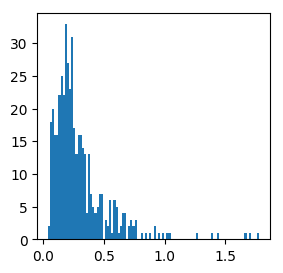

In [49]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(10)
neigh.fit(x_encoded)

[distance_knn,kneighbors]=neigh.kneighbors(x_encoded, 2, return_distance=True)
nearest=distance_knn[:,1]
fig = plt.figure(dpi=100,figsize=(3,3))
plt.hist(nearest,bins=100)
plt.show

In [50]:
from scipy import stats

stats.describe(nearest)

DescribeResult(nobs=455, minmax=(0.03969711934720675, 1.779990945878152), mean=0.2969735960525093, variance=0.053984626916430495, skewness=2.7633117844012176, kurtosis=11.184247111341262)

<function matplotlib.pyplot.show(*args, **kw)>

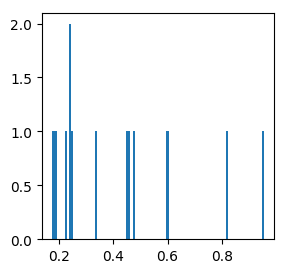

In [51]:
fig = plt.figure(dpi=100,figsize=(3,3))
plt.hist(nearest[indicesHd],bins=100)
plt.show

In [52]:
stats.describe(nearest[indicesHd])

DescribeResult(nobs=13, minmax=(0.17638380626268027, 0.9531087808931212), mean=0.4172507515020491, variance=0.0610167459776039, skewness=1.0202171317322057, kurtosis=-0.08771838012464261)

In [65]:
calendar_info.loc[np.where(nearest>=1)]

,ds,month,weekday,is_weekday,is_holiday_day,clear,mist,significant,extreme
322,2012-06-01,6,4,1,0.0,0,0,1,0
333,2012-06-12,6,1,1,0.0,0,0,1,0
369,2012-08-10,8,4,1,0.0,0,0,1,0
384,2012-09-06,9,3,1,0.0,0,0,1,0
386,2012-09-08,9,5,0,0.0,0,0,1,0
396,2012-09-18,9,1,1,0.0,0,0,1,0
399,2012-10-02,10,1,1,0.0,0,0,1,0
416,2012-10-19,10,4,1,0.0,0,0,1,0


2013-01-19 and 2017-01-21 were big snowy events in France. 2013-03-03 and 2014-12-01 are harder to interpret

In [54]:
indicesNear=[i for i in range(0,len(nearest)) if nearest[i]>=1]
nearest[np.where(nearest>=1)]

array([1.66586781, 1.38231351, 1.77999095, 1.02717224, 1.7041135 ,
       1.26839864, 1.44090248, 1.03896171])

<bound method Figure.show of <Figure size 1000x300 with 8 Axes>>

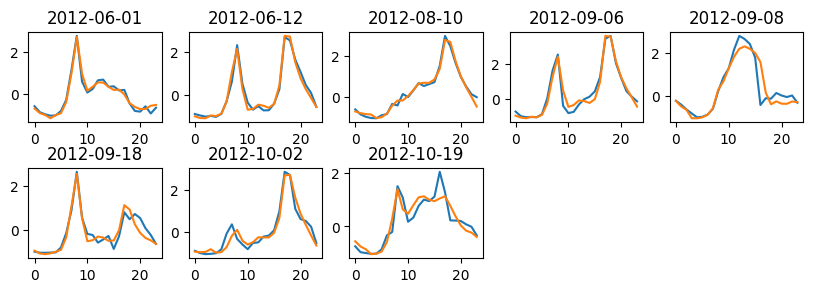

In [55]:
nPlots=len(indicesNear)#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,3))
for i in range(1, nPlots+1):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=indicesNear[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_info.ds.dt.date.iloc[indice])
fig.show

# Conclusions
- 3 dimensions covers most of the information for the variety of daily load curves 
- We recovered with this simple linear model the two main features that caracterizes electrical consumption: weekday and temperature
- Holidays are not yet well predicted and represented, although we know they are an important atypical factor.
- We however detect that holidays all look alike weekend days
- We discover some first interpretable events.

